In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014

from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import numpy as np
from scipy import optimize as opt

from astropy import units

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import calcGrid

from auriga_basics import *
from auriga_functions import *

import datetime

%matplotlib inline

In [3]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [4]:
maxr = s.galrad
maxr = 0.01 #Mpc
iall, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) )
igas, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 0) )
idm, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
istars, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 4) )
mask = iall    

(x_kpc, y_kpc, z_kpc), (vx_kms, vy_kms, vz_kms), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, mask)
(R_kpc, phi, z_kpc), (vR_kms, vphi, vz_kms) = get_cylindrical_vectors(s, sf, mask)


(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, mask)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, mask)

#rho, Rbin, z, vol = fitting_dens(s.mass[mask][np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], R_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], z_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], nbins = 41)
#rho, R, z, vol = fitting_dens(s)
r_dm_kpc = 1000. * s.r()[idm]
(R_dm_kpc, phi, z_dm_kpc), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, idm)
r_gas_kpc = 1000. * s.r()[igas]
r_stars_kpc = 1000. * s.r()[istars]
r_all_kpc = 1000. * s.r()[iall]
pot_dm = s.pot[idm]
pot_m_dm = s.pot[idm] * s.mass[idm]
pot_gas = s.pot[igas]
pot_stars = s.pot[istars]
pot_all = s.pot[iall]


Text(0,0.5,'pot [??]')

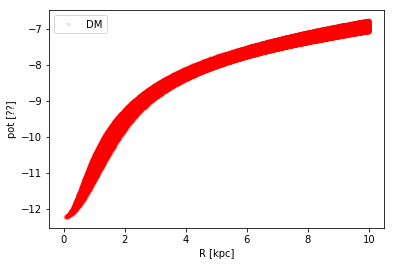

In [5]:
#plt.plot(r_stars_kpc, pot_stars, 'b.', alpha = 0.01, label = 'stars')
#plt.plot(r_gas_kpc, pot_gas, 'g.', alpha = 0.01, label = 'gas')
plt.plot(r_dm_kpc, pot_m_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [??]')

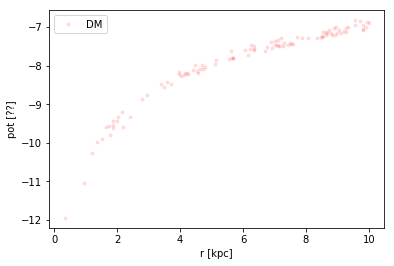

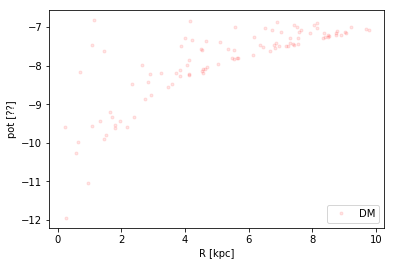

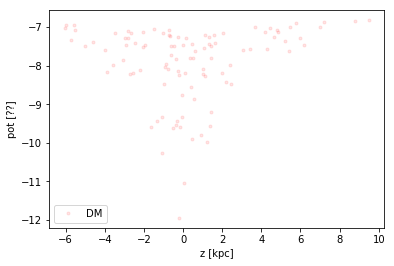

In [ ]:
#dm particle (random) selection

import random
a = np.array(random.sample(list(enumerate(pot_m_dm)),101))
rand_ind = a[:,0].astype(int)
rand_pot_dm = a[:, 1]
rand_r_dm = r_dm_kpc[rand_ind]
rand_R_dm = R_dm_kpc[rand_ind]
rand_z_dm = z_dm_kpc[rand_ind]

plt.plot(rand_r_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('r [kpc]')
plt.ylabel('pot [??]')
plt.show()
plt.plot(rand_R_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [??]')
plt.show()
plt.plot(rand_z_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('z [kpc]')
plt.ylabel('pot [??]')
plt.show()


In [12]:
res_rms


     fun: 7.2195292831717985
     jac: array([ -4.35113907e-06,   2.12600231e-02,   7.73618817e-02,
        -1.10507011e-04,   7.36019611e-02,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 312
     nit: 38
    njev: 38
  status: 0
 success: True
       x: array([  1.36704927e-01,   8.64863387e-18,   6.82610706e-01,
         1.33856267e+01,   3.17389294e-01,   2.00000000e+02])

In [13]:
res_chi

     fun: 589.8665071708206
     jac: array([ -5.80596924e-03,   3.80289459e+00,   1.29878159e+01,
        -1.24435425e-02,   1.23725586e+01,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 579
     nit: 69
    njev: 69
  status: 0
 success: True
       x: array([  1.38366481e-01,   0.00000000e+00,   7.18888889e-01,
         1.48870266e+01,   2.81111111e-01,   2.00000000e+02])

In [17]:
a_mp_rms, b_mp_rms, n_mp_rms = res_rms.x[0], res_rms.x[1], res_rms.x[2]
a_nfw_rms , n_nfw_rms = res_rms.x[3]  , res_rms.x[4]
#a_he, n_he = res.x[5],  res.x[6]
a_mp_chi, b_mp_chi, n_mp_chi = res_chi.x[0], res_chi.x[1], res_chi.x[2]
a_nfw_chi , n_nfw_chi = res_chi.x[3]  , res_chi.x[4]

In [18]:
mp_rms = MNpot(a = a_mp_rms, b = b_mp_rms, normalize = n_mp_rms, ro = r0, vo = v0)
nfwp_rms = NFWpot(a = a_nfw_rms, normalize = n_nfw_rms, ro = r0, vo = v0)
#hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw), ro = r0, vo = v0)
    
pot_rms = [mp_rms,nfwp_rms]#,hep]

mp_chi = MNpot(a = a_mp_chi, b = b_mp_chi, normalize = n_mp_chi, ro = r0, vo = v0)
nfwp_chi = NFWpot(a = a_nfw_chi, normalize = n_nfw_chi, ro = r0, vo = v0)
    
pot_chi = [mp_chi,nfwp_chi]#,hep]

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  wa

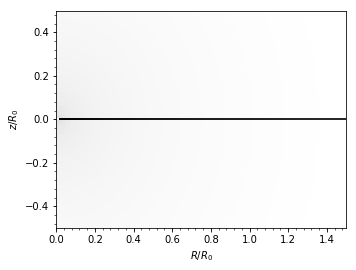

In [22]:
plotDensities(pot_rms,nrs=101,nzs=101, log = True)

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/MiyamotoNagaiPotential.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  (R**2.+asqrtbz**2.)**2.5/sqrtbz**3./4./nu.pi*self._b2

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/MiyamotoNagaiPotential.py:154: RuntimeWarning: invalid value encountered in double_scalars
  (R**2.+asqrtbz**2.)**2.5/sqrtbz**3./4./nu.pi*self._b2

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)



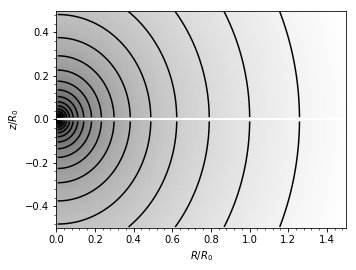

In [23]:
plotDensities(pot_chi,nrs=101,nzs=101, log = True)